# Numerical Solutions of The Schrodinger Equation
### 1D Time-Dependent Schrodinger Equation

$$\left(\frac{-\hbar^2}{2m}\frac{d^2}{dx^2} + V(x,t)\right)\Psi(x,t) = i\hbar\Psi(x,t)$$
### 1D Time-Independent Schrodinger Equation
$$\left(\frac{-\hbar^2}{2m}\frac{d^2}{dx^2} + V(x)\right)\Psi(x) = E\Psi(x)$$

The aim of this project is to use numerical methods to find the solutions, and thus energy eigenvalues, of the Schrodinger equation. The accuracy and time complexity of each method will be compared in an attempt to find the best tradeoff between accuracy and time complexity. This is an initial-value problem where the boundary conditions of the problem will also be used in finding a solution. 

Firstly, we need to solve the following differential equation numerically:
$$\frac{d^2\Psi}{dx^2} = \left(V(x)-E\right)\frac{2m}{\hbar^2}\Psi(x)$$
RK4, RK8 or Numerov's algorithm can be used to solve this DE. We can then use the boundary conditions, which the potential in the scenario determines, and an extra numerical method such as the bisection method or the Newton-Raphson method to home in on the energy eigenvalues.

# Infinite Square Well

Situation with two barriers at x = -L/2 and x = L/2 creating a well of width L. We know that $V(x=\frac{-L}{2}) = \infty$ and $V(x=\frac{L}{2}) = \infty$. This means that the wavefunction is zero at the barrier and beyond because the particle in the well will not be found beyond the barriers. Our boundary counditions are thus two points, x = -L/2 and x = L/2, where the wavefunction must be zero. 

This problem can be solved analytically to find that 
$$E_n = \frac{n^{2}\hbar^{2}\pi^2}{2mL^2}$$

In [1]:
# Define some useful constants and import modules
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
from time import process_time
planck = 6.62607004 * 10**-34
hbar = planck/(2*math.pi)
funcharge = 1.6*10**-19

# Module imported for debugging
from IPython.core.debugger import set_trace

In [2]:
# Parent class defined
# Properties of the system are stored as attributes here
# The attributes are assigned to an instance (object) of this class
# The functions used to do the runge kutta, bisection and calculation of the eigenvalues are defined here as methods
# Very similar, just to need to use self.method when calling that method in other methods, as you'll see below
# Methods can easily access and use an object's attributes and also change an object's attributes
# yin1 and yin2 assigned to class variables since these are constant for the infinite and finite wells
class Well():
    yin1 = np.array([0,1], dtype = np.float64)    
    yin2 = np.array([1,0], dtype = np.float64)
    def __init__(self, mass, length, step_pos, step_E_initial, bisection_lim):
        self.m = mass
        self.L = length
        self.V = 0                 # Potential we're working with
        self.wave_deriv = False    # See the wave_value method
        self.h = step_pos          # Step size in space
        self.x_max = length/2
        self.Estep = step_E_initial     # See the ab_finder method
        self.lim = bisection_lim        # See the bisection_method method
        
    
    # Method returns an array containing the   
    def deriv(self, y, x, E):
        return np.array([y[1],(self.V-E)*(2*(self.m)/hbar**2)*y[0]], dtype = np.float64)    



    # Method defines a single step for rk4
    def rk4(self, y, dy, x, E):
        k1 =dy(y, x, E)
        k2 =dy(y+(self.h)/2*k1, x + (self.h)/2, E)
        k3 =dy(y+(self.h)/2*k2, x + (self.h)/2, E)
        k4 =dy(y+(self.h)*k3, x + (self.h), E)
        y = y + self.h*(k1+2*k2+2*k3+k4)/6
        x = x + self.h
        return (x,y)

    # Method uses for loops and rk4 function to calculate the value of the wavefunction at the boundary
    # Two if loops for the option to try both cos and sin initial conditions, since the solutions can be odd or even
    # The parameter 'wave_deriv' can be passed as True or False (False by default to reduce the amount of code written)
    # If passed as True, the method returns an array, y, containing both the y variable and its derivative at the point of interest
    # If passed as False, only the y variable's value at the point of interest is returned (reduces code written this way)
    # Also makes sense to return the array instead of doing two separate loops for y and its derivative
    def wave_value(self, E, cos=False, sin=False):
        x = 0     # starting position
        if sin == True:
            y = Well.yin1
            for i in range(int((self.x_max)/(self.h))):
                x,y = self.rk4(y, self.deriv, x, E)
            if self.wave_deriv == False:
                return y[0]
            else:
                return y[1] + (((2*self.m*E)**(1/2))/hbar)*y[0]
        if cos == True:
            y = Well.yin2
            for i in range(int((self.x_max)/(self.h))):
                x,y = self.rk4(y, self.deriv, x, E)
            if self.wave_deriv == False:
                return y[0]
            else:
                return y[1] + (((2*self.m*E)**(1/2))/hbar)*y[0]
        else:
            print("sin or cos needs to be chosen")
            return
    

    # Method defined to find the order of magnitude of the passed parameter 'value'
    def pow_finder(self, value):
        val = format(float(value), '.40f')
        if val[0] == '0':
            for i, elem in enumerate(val):
                if elem != '0' and elem != '.':
                    return -(i-1)       
        else:
            for i, elem in enumerate(val):
                if elem == '.':
                    return i-1
                
    
    
    # Method defined to find the 'a' and 'b' values for use in the bisection method
    # wave_value method is evaluated with current E value (zero initially as a safe guess)
    # If the method returns a value which is less than zero, E is shifted by the step value
    # Following this, E_low and E_high are shifted accordlingly, which is repeated in a loop
    # Once E reaches a value which changes the sign, the loop ends and the current E_low and E_high values are used as 'a' and 'b'
    # If the initial E value used gives a wave_value return of greater than zero, then the loop can be adjusted as shown below
    def ab_finder(self, step, E, cos = False, sin = False):
        E_low = E                   # Starting 'a' value of E-(step value) to be shifted correctly with E in the while loop
        E_high = E + step           # Starting 'b' value. 2*step is to try to prevent ab_finder from getting stuck on the same roots 
    
        if sin == True:
            if self.wave_value(E=E_high, sin=True) < 0:
                while self.wave_value(E=E_high, sin=True) < 0:
                    E_low += step
                    E_high += step    
                return [E_low, E_high]
            else:
                while self.wave_value(E=E_high, sin=True) > 0:
                    E_low += step
                    E_high += step    
                return [E_low, E_high]
        elif cos == True:
            if self.wave_value(E=E_high, cos=True) < 0:
                while self.wave_value(E=E_high, cos=True) < 0:
                    E_low += step
                    E_high += step    
                return [E_low, E_high]
            else:
                while self.wave_value(E=E_high, cos=True) > 0:
                    E_low += step
                    E_high += step
                return [E_low, E_high]
        else:
            print("You need to choose sin or cos")
            return
    
    
    # Method defines the bisection method, which is used to converge on the energy eigenvalues
    # Option to pick sin or cos initial conditions
    # Lim parameter lets you approximately choose the uncertainty to which the energy will be found
    # 'a' and 'b' are the initial guesses, either side of the root
    # Two while loops for each cos or sine choice
    # The while loop keeps running until the length of the interval (b-a) is less than the lim value chosen
    # Function returns (a+b)/2 at the end, which is an approximation that the energy eigenvalue lies halfway between the final 'a' and 'b' values
    def bisection(self, a, b, cos = False, sin = False):
        # Initially set E equal to 'a' parameter so that we can evaluate wave_value with the E_low value from ab_finder
        # The value wave_value returns will determine how the function should try and determine the energy eigenvalue
    
        if sin == True:
            if self.wave_value(E=a, sin=True) < 0:
                while b - a > self.lim:
                    c = (a+b)/2
                    if self.wave_value(E=a+c, sin=True) < 0:
                        a = c
                    if self.wave_value(E=a+c, sin=True) > 0:
                        b = c
            else:
                while b - a > self.lim:
                    c = (a+b)/2
                    if self.wave_value(E=a+c, sin=True) < 0:
                        a = c
                    if self.wave_value(E=a+c, sin=True) > 0:
                        b = c
            
        if cos == True:
            if self.wave_value(E=a, cos=True) < 0:
                while b - a > self.lim:
                    c = (a+b)/2
                    if self.wave_value(E=a+c, cos=True) < 0:
                        a = c
                    if self.wave_value(E=a+c, cos=True) > 0:
                        b = c
            else:
                while b - a > self.lim:
                    c = (a+b)/2
                    if self.wave_value(E=a+c, cos=True) < 0:
                        a = c
                    if self.wave_value(E=a+c, cos=True) > 0:
                        b = c
        return (a+b)/2       

In [3]:
class InfiniteWell(Well):
    
    def __init__(self, mass, length, step_pos, step_E_initial, bisection_lim):
        super().__init__(mass, length, step_pos, step_E_initial, bisection_lim)
        self.wave_deriv = False
        self.V = 0
    
    def analytic_infwell(self, n):
        return (n**2)*(hbar**2)*(math.pi**2)/(2*self.m*(self.L**2))
        
    
    def inf_well(self):
        #set_trace()
        stepEc = self.Estep              
        stepEs = self.Estep                                      
        EcArray = [0]                         
        EsArray = [0]                         # List, containing only two zeros, which will hold the energy eigenvalues
        Ec = 0                                # Initialisation of the variable used to hold even solution eigenvalues 
        Es = 0                                # Initialisation of the variable used to hold odd solution eigenvalues
    
    
        
        # stepEc and stepEs change depending on the size of Ec and Es
        # Even and odd eigenvalues found independently so that we don't have to keep shifting our initial energy value in ab_finder
        while len(EcArray) < 6 and len(EsArray) < 6:
            Ec = self.bisection(self.ab_finder(E=Ec, step = stepEc, cos=True)[0],
                           self.ab_finder(E=Ec, step = stepEc, cos=True)[1], cos=True)
        
            Es = self.bisection(self.ab_finder(E=Es, step = stepEs, sin=True)[0], 
                           self.ab_finder(E=Es, step = stepEs, sin=True)[1], sin=True)
        
            stepEc = 10**(self.pow_finder(Ec)-1)
            stepEs = 10**(self.pow_finder(Es)-1)
            EcArray += [Ec]
            EsArray += [Es]
    
        # Arrays sliced to get rid of the zeros
        # Arrays added together to get all eigenvalues in the no particular order
        # Total array sorted in ascending order 
        EcArray = EcArray[1:len(EcArray)]
        EsArray = EsArray[1:len(EsArray)]
        Eigens = EcArray + EsArray
        Eigens.sort()
        
    
        return Eigens
    
    def value_print(self):
        Anal_Eigens = [self.analytic_infwell(n) for n in range(1, 11)]
        Num_Eigens = self.inf_well()
        percent_diff = [((Num_Eigens[i] - Anal_Eigens[i])/Anal_Eigens[i])*100 for i in range(10)]
        print([["Numerical"], ["Analytic"], ["Percentage Difference"]])
        for i in range(10):
            print([Num_Eigens[i]/funcharge, Anal_Eigens[i]/funcharge, percent_diff[i]])
        absolute_vector_func = np.vectorize(abs)    
        percent_diff = np.array(percent_diff)
        percent_diff = absolute_vector_func(percent_diff)
        print("Average Percentage Difference: {}".format(np.mean(percent_diff)))
        
        
    
    def probdensity(self, E, sin, cos):
        x = 0     # Starting position
        xs = []   # Empty array which will hold x values
        Ps = []   # Empty array which will hold prob density values
        if sin == True:
            y = Well.yin1
            for i in range(int((self.x_max)/(self.h))):
                x,y = self.rk4(y, self.deriv, x, E)
                xs.append(x)
                Ps.append(y[0]**2)
            return xs, Ps
                
        else:
            y = Well.yin2
            for i in range(int((self.x_max)/(self.h))):
                x,y = self.rk4(y, self.deriv, x, E)
                xs.append(x)
                Ps.append(y[0]**2)
            return xs, Ps
    
    def plotter(self):
        Eigens = self.inf_well()
        
        x1, P1 = self.probdensity(cos=True, sin= False, E = Eigens[0])
        P1neg = P1[::-1]
        P1 = P1neg + P1
        x1neg = []
        for i in range(len(x1)):
            x1neg.append(-x1[-1-i])
        x1 = x1neg + x1    
        
        x2, P2 = self.probdensity(sin=False, cos = True, E = Eigens[2])
        P2neg = P2[::-1]
        P2 = P2neg + P2
        x2neg = []
        for i in range(len(x2)):
            x2neg.append(-x2[-1-i])
        x2 = x2neg + x2
        
        x3, P3 = self.probdensity(cos=True, sin = False, E = Eigens[4])
        P3neg = P3[::-1]
        P3 = P3neg + P3
        x3neg = []
        for i in range(len(x3)):
            x3neg.append(-x3[-1-i])
        x3 = x3neg + x3
        
        plt.plot(x1, P1, color = "red")
        plt.plot(x2, P2, color = "green")
        plt.plot(x3, P3, color = "blue")
        
        plt.xlabel("$x$/m")
        plt.ylabel("P($x$)")
        plt.title("The Probability Density Functions of The First Three Even Wave Functions")
        plt.xlim(-0.5*10**-9,0.5*10**-9)
        
        plt.show()

In [4]:
particle = InfiniteWell(step_pos=10**-12, step_E_initial=10**-21, length=5*10**-10, mass=9.11*10**-31,
                     bisection_lim = 10**-22)
start = process_time()
particle.value_print()
end = process_time()
print(end-start)

[['Numerical'], ['Analytic'], ['Percentage Difference']]
[1.5060546875000023, 1.506064907209989, -0.0006785703549582808]
[6.024804687500094, 6.024259628839956, 0.009047728579430805]
[13.506298828124972, 13.554584164889901, -0.35622883134992345]
[24.087548828124998, 24.097038515359824, -0.039381134859285856]
[37.25660400390625, 37.651622680249716, -1.0491411743342502]
[54.08785400390622, 54.218336659559604, -0.24066148777800658]
[74.13129882812484, 73.79718045328946, 0.45275222275852606]
[96.5875488281249, 96.3881540614393, 0.20686646468869785]
[117.88148956298816, 121.9912574840091, -3.3689036458695822]
[152.83735809326163, 150.60649072099886, 1.4812557955390415]
Average Percentage Difference: 0.7204917056111704
18.703125


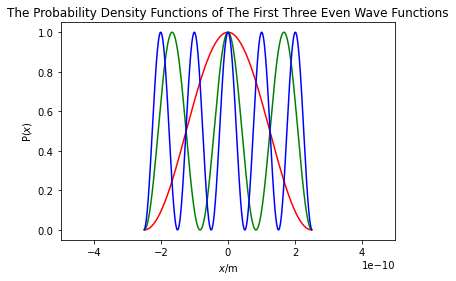

In [5]:
particle.plotter()

In [6]:
(particle.probdensity(E=3.389*1.6*10**-19, sin=False, cos=True))[1]

[0.999911166912649,
 0.9996446992158853,
 0.9992006915943011,
 0.9985793018181682,
 0.9977807506873756,
 0.9968053219529723,
 0.9956533622163426,
 0.9943252808060459,
 0.9928215496323698,
 0.9911427030196451,
 0.989289337516383,
 0.987262111683302,
 0.9850617458593199,
 0.9826890219055946,
 0.9801447829277029,
 0.9774299329760581,
 0.9745454367246716,
 0.9714923191283735,
 0.968271665058612,
 0.964884618917964,
 0.9613323842334923,
 0.9576162232290928,
 0.9537374563769857,
 0.9496974619285093,
 0.9454976754243825,
 0.9411395891846104,
 0.9366247517782155,
 0.9319547674729802,
 0.9271312956653994,
 0.9221560502910426,
 0.9170307992155374,
 0.9117573636063891,
 0.9063376172858625,
 0.9007734860651503,
 0.8950669470600714,
 0.889220027988537,
 0.8832348064500377,
 0.8771134091874042,
 0.870858011331107,
 0.8644708356263627,
 0.8579541516433205,
 0.8513102749706097,
 0.8445415663925377,
 0.8376504310502255,
 0.8306393175869842,
 0.8235107172782324,
 0.8162671631462655,
 0.8089112290601909,

## Time taken for 0.14% average percentage difference WITHOUT variable step size function
200 seconds taken to find 10 eigenvalues in total. 

### Accuracy: 0.14% average percentage difference

Parameters:
step size - 10^-12
length - 10^-9




## Time taken WITH variable step size function
22 seconds taken to find 10 eigenvalues in total.

### Accuracy: 0.62% average percentage difference

Parameters:
same as above


# Finite Square Well

The functionality of the tools we used to solve for the infinite well can be extended to the case of the finite square well. In this case, the potential has the form: 

$V(x) = 0$ for $x<\frac{-L}{2}$ and $x>\frac{L}{2}$

$V(x) = -V$ for $\frac{-L}{2} < x < \frac{L}{2}$

We need to solve  $$\frac{d^2\Psi}{dx^2} = \left(V(x)-E\right)\frac{2m}{\hbar^2}\Psi(x)$$ to find the energy eigenvalues $E_{n}$.

Boundary condition: $$\frac{d\Psi(\frac{L}{2})}{dx} + \alpha\Psi(\frac{L}{2}) = 0$$ 
where $\alpha = \frac{\sqrt{2mE}}{\hbar}$

In [7]:
# FiniteWell class created as a subclass of the Well class so that we don't have to define the exact same methods again
# super().__init__() allows us to inherit the attributes 
class FiniteWell(InfiniteWell):
    def __init__(self, mass, length, potential, step_pos, step_E_initial, bisection_lim):
        super().__init__(mass, length, step_pos, step_E_initial, bisection_lim)
        self.wave_deriv = True
        self.V = potential  

In [8]:
finite_particle = FiniteWell(step_pos=10**-12, step_E_initial=10**-21, length=5*10**-10, mass=9.11*10**-31,
                        potential = 60*1.6*10**-19, bisection_lim = 10**-22)
for value in finite_particle.inf_well():
    print(value/funcharge)

61.24980468750744
65.0310546875083
71.25010986328864
77.5312454223716
96.24991912842539
108.78105468750832
121.25010986328869
146.28124542237163
171.24991912842543
202.5310546875083
